In [1]:
import joblib
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix

from cogpred.utils.configuration import get_config

config = get_config()
conn_dir = config["connectivity_matrices"]

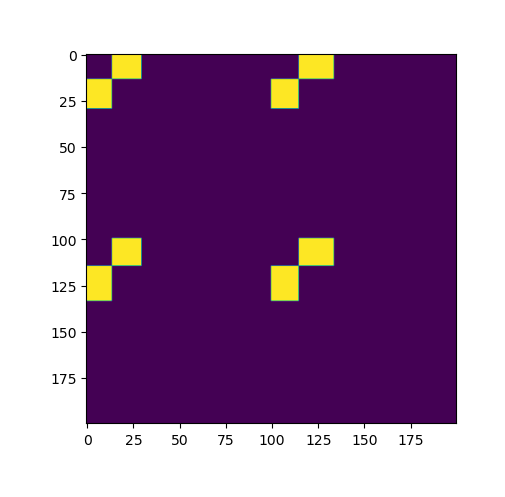

In [2]:
from neuroginius.synthetic_data.generation import generate_topology, generate_topology_net_interaction
from neuroginius.atlas import Atlas


refnet = "Vis"
atlas = Atlas.from_name("schaefer200")

topology = generate_topology(refnet, atlas.macro_labels)
topology = generate_topology_net_interaction((refnet, "SomMot"), atlas.macro_labels)
#networks = np.unique(atlas.macro_labels)
#
#for network in networks:
#    new = generate_topology_net_interaction((refnet, network), atlas.macro_labels)
#    topology += new

topology = np.where(topology != 0, 1, 0)
plt.imshow(topology)
plt.show()

In [3]:
ATLAS = "schaefer200"
k = 3

import os
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(config["output_dir"], k=k, feat="fc", atlas=ATLAS)
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 12 subjects because of lacking MMMSE


In [4]:
# Set non default to 0, transform to vec, and extract non zero coefficients
matrices *= topology

X = []
for mat in matrices:
    vec = sym_matrix_to_vec(mat, discard_diagonal=True)
    vec_idx = np.flatnonzero(vec) # Should only be computed once
    X.append(vec[vec_idx])

X = np.stack(X)
y = metadata.cluster_label
assert len(X) == len(y)

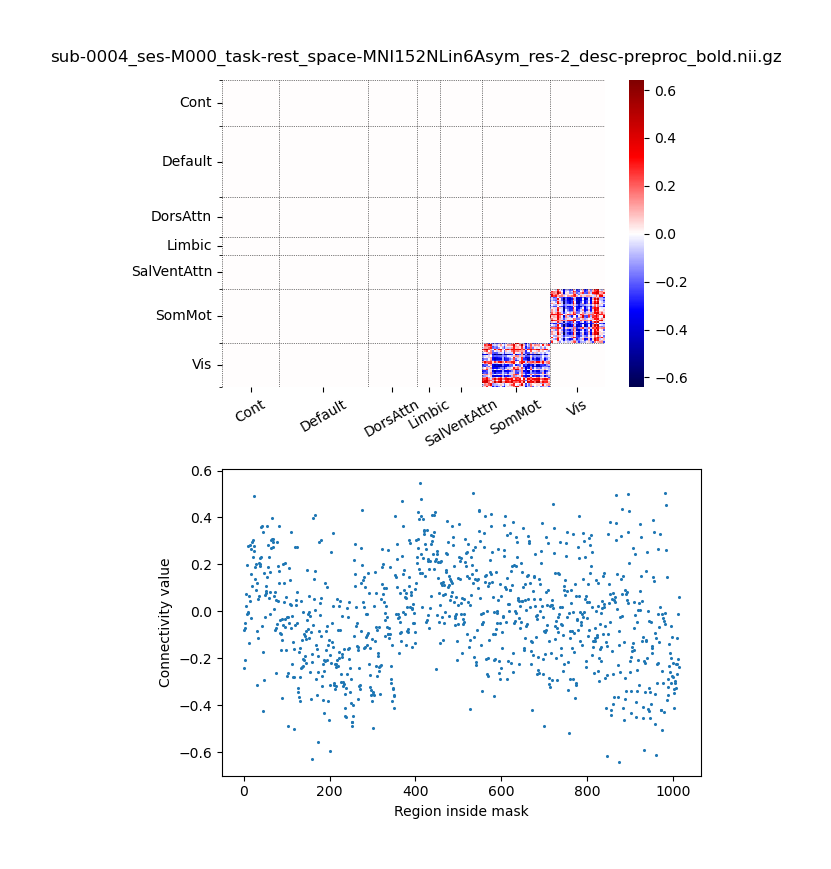

In [5]:
i = 2
row = metadata.iloc[i]
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

plot_matrix(matrices[i], atlas, axes=ax[0])

ax[1].scatter(np.arange(X.shape[1]), X[i], s=5)
ax[1].set_xlabel("Region inside mask")
ax[1].set_ylabel("Connectivity value")

fig.suptitle(f"{row.file_basename}")
fig.tight_layout()
plt.show()

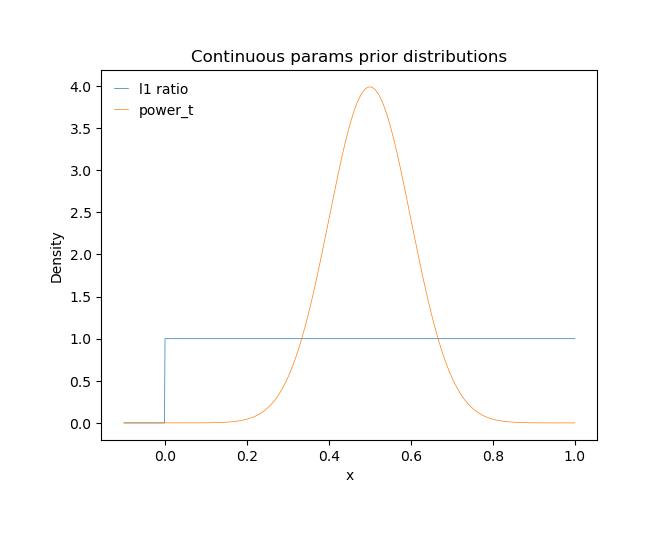

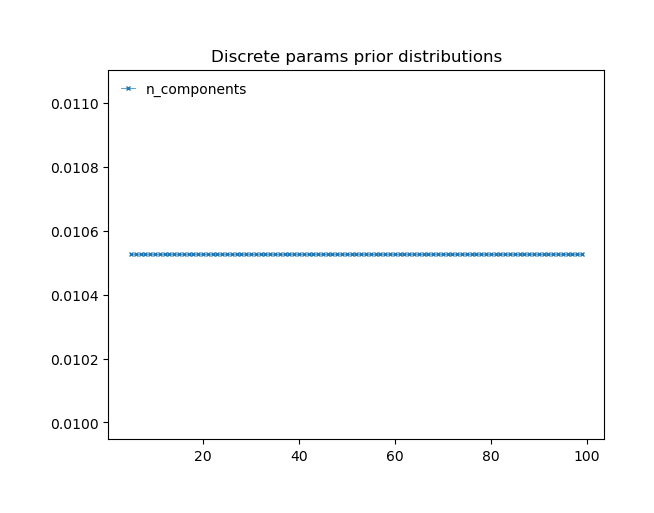

In [6]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


#plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

n_features = X.shape[1]
n_comps = list(range(5, 100))
dc = np.ones((len(n_comps))) * 1 / len(n_comps)
plt.plot(n_comps, dc, label="n_components", marker="x")
plt.title("Discrete params prior distributions")

plt.legend()
plt.show()

In [7]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
    "reduction__n_components": n_comps
}

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.model_selection import (
    cross_validate, cross_val_predict, KFold, RandomizedSearchCV, StratifiedKFold
)

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import cross_val_predict, KFold, RandomizedSearchCV, cross_val_score
from cogpred.supervised import macro_f1

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)

clf = Pipeline(
    [
    ("scaler", preprocessing.StandardScaler()),
    ("reduction", PCA()),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=1999)


search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [9]:
search.fit(X, y)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,param_reduction__n_components,params,...,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
11,0.307536,0.049975,0.006636,0.000933,0.005405,0.114456,hinge,0.625902,73,"{'classifier__alpha': 0.005404852195663738, 'c...",...,0.419783,0.331489,0.466577,0.396238,0.420653,0.331260,0.394042,0.390194,0.043920,1
93,0.403659,0.039554,0.012923,0.008453,0.002441,0.549702,modified_huber,0.461714,68,"{'classifier__alpha': 0.002440884101148569, 'c...",...,0.453968,0.364266,0.395327,0.345274,0.374770,0.355368,0.412459,0.381968,0.034417,2
49,0.425363,0.068634,0.007268,0.002690,0.000408,0.360814,modified_huber,0.552746,80,"{'classifier__alpha': 0.00040837115745048064, ...",...,0.367296,0.365418,0.445112,0.355781,0.390912,0.354097,0.426314,0.381754,0.033662,3
37,0.338155,0.072832,0.011342,0.007449,0.000610,0.420879,hinge,0.532444,75,"{'classifier__alpha': 0.0006103297092081014, '...",...,0.371845,0.306038,0.421509,0.350245,0.379212,0.338172,0.452458,0.375417,0.043290,4
25,0.336595,0.072518,0.006361,0.000923,0.000801,0.829174,log_loss,0.459023,63,"{'classifier__alpha': 0.0008013551629935216, '...",...,0.474654,0.370966,0.338041,0.358602,0.403304,0.338101,0.340918,0.374419,0.043188,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.293956,0.098216,0.013181,0.007279,0.000358,0.899868,hinge,0.708548,24,"{'classifier__alpha': 0.0003575900346893278, '...",...,0.314835,0.275660,0.307626,0.330198,0.363105,0.361251,0.252378,0.312523,0.036320,96
40,0.084183,0.007917,0.006075,0.000476,0.000119,0.598668,hinge,0.459155,6,"{'classifier__alpha': 0.00011889356819672398, ...",...,0.321200,0.337617,0.365451,0.330058,0.220699,0.274033,0.329485,0.307600,0.042920,97
10,0.101492,0.033788,0.008014,0.002694,0.003440,0.816380,modified_huber,0.438638,10,"{'classifier__alpha': 0.0034403013239692154, '...",...,0.336388,0.358449,0.299579,0.315891,0.287485,0.304442,0.230537,0.302532,0.035532,98
20,0.104369,0.020036,0.009295,0.008269,0.000696,0.564681,log_loss,0.401481,9,"{'classifier__alpha': 0.0006958956721403251, '...",...,0.265824,0.228607,0.359852,0.289494,0.279109,0.338695,0.334321,0.295598,0.041657,99


Text(0.5, 0.92, 'Randomized grid search')

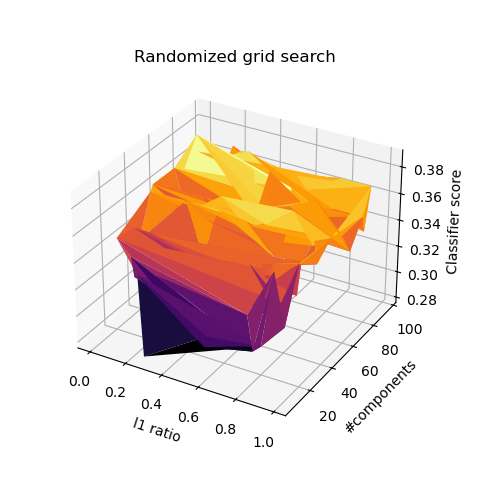

In [10]:
from matplotlib import cm

x = cv_results.param_classifier__l1_ratio.values
y = cv_results.param_reduction__n_components.values
z = cv_results.mean_test_score.values
yy, xx = np.meshgrid(y, x)


fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.plot_trisurf(x, y, z, cmap=cm.inferno, linewidth=0.2)
plt.xlabel("l1 ratio")
plt.ylabel("#components")
ax.set_zlabel("Classifier score")
ax.set_title("Randomized grid search")



In [11]:
test_scores = cross_val_score(
    search, X, y, cv=outer_cv, n_jobs=8, scoring=macro_f1, verbose=1
) # TODO Get hyperparameters
test_scores

ValueError: Found input variables with inconsistent numbers of samples: [1222, 100]

In [ ]:
import joblib
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200/test_scores.joblib']